In [13]:
print("\nAccuracy Score:")
print(accuracy_score(Y_test, Y_pred))


Accuracy Score:
0.7538461538461538


In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.ensemble import (
    RandomForestClassifier, BaggingClassifier,
    AdaBoostClassifier, GradientBoostingClassifier
)
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

# >>> Use your dataset path here <<<
DATA_PATH = r"C:\Users\user\Data-Science-main\glass.xlsx"

# If your sheet is named differently, adjust sheet_name
df = pd.read_excel(DATA_PATH, sheet_name="glass")
print("Shape:", df.shape)
print(df.head())
print(df.info())


Shape: (214, 10)
        RI     Na    Mg    Al     Si     K    Ca   Ba   Fe  Type
0  1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.0  0.0     1
1  1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.0  0.0     1
2  1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.0  0.0     1
3  1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.0  0.0     1
4  1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.0  0.0     1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 1

In [3]:
# ===== 1) EDA: Structure, Missing, Outliers/Inconsistencies =====
print("\n=== Summary (describe) ===")
print(df.describe(include="all"))

print("\n=== Missing values per column ===")
print(df.isna().sum().sort_values(ascending=False))

# Basic outlier check using IQR (reports counts, does not drop)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
iqr_outliers = {}
for c in num_cols:
    q1, q3 = df[c].quantile([0.25, 0.75])
    iqr = q3 - q1
    low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
    iqr_outliers[c] = int(((df[c] < low) | (df[c] > high)).sum())
print("\n=== Approx. outlier counts by IQR (not dropping) ===")
print(pd.Series(iqr_outliers).sort_values(ascending=False))


=== Summary (describe) ===
               RI          Na          Mg          Al          Si           K  \
count  214.000000  214.000000  214.000000  214.000000  214.000000  214.000000   
mean     1.518365   13.407850    2.684533    1.444907   72.650935    0.497056   
std      0.003037    0.816604    1.442408    0.499270    0.774546    0.652192   
min      1.511150   10.730000    0.000000    0.290000   69.810000    0.000000   
25%      1.516522   12.907500    2.115000    1.190000   72.280000    0.122500   
50%      1.517680   13.300000    3.480000    1.360000   72.790000    0.555000   
75%      1.519157   13.825000    3.600000    1.630000   73.087500    0.610000   
max      1.533930   17.380000    4.490000    3.500000   75.410000    6.210000   

               Ca          Ba          Fe        Type  
count  214.000000  214.000000  214.000000  214.000000  
mean     8.956963    0.175047    0.057009    2.780374  
std      1.423153    0.497219    0.097439    2.103739  
min      5.430000 

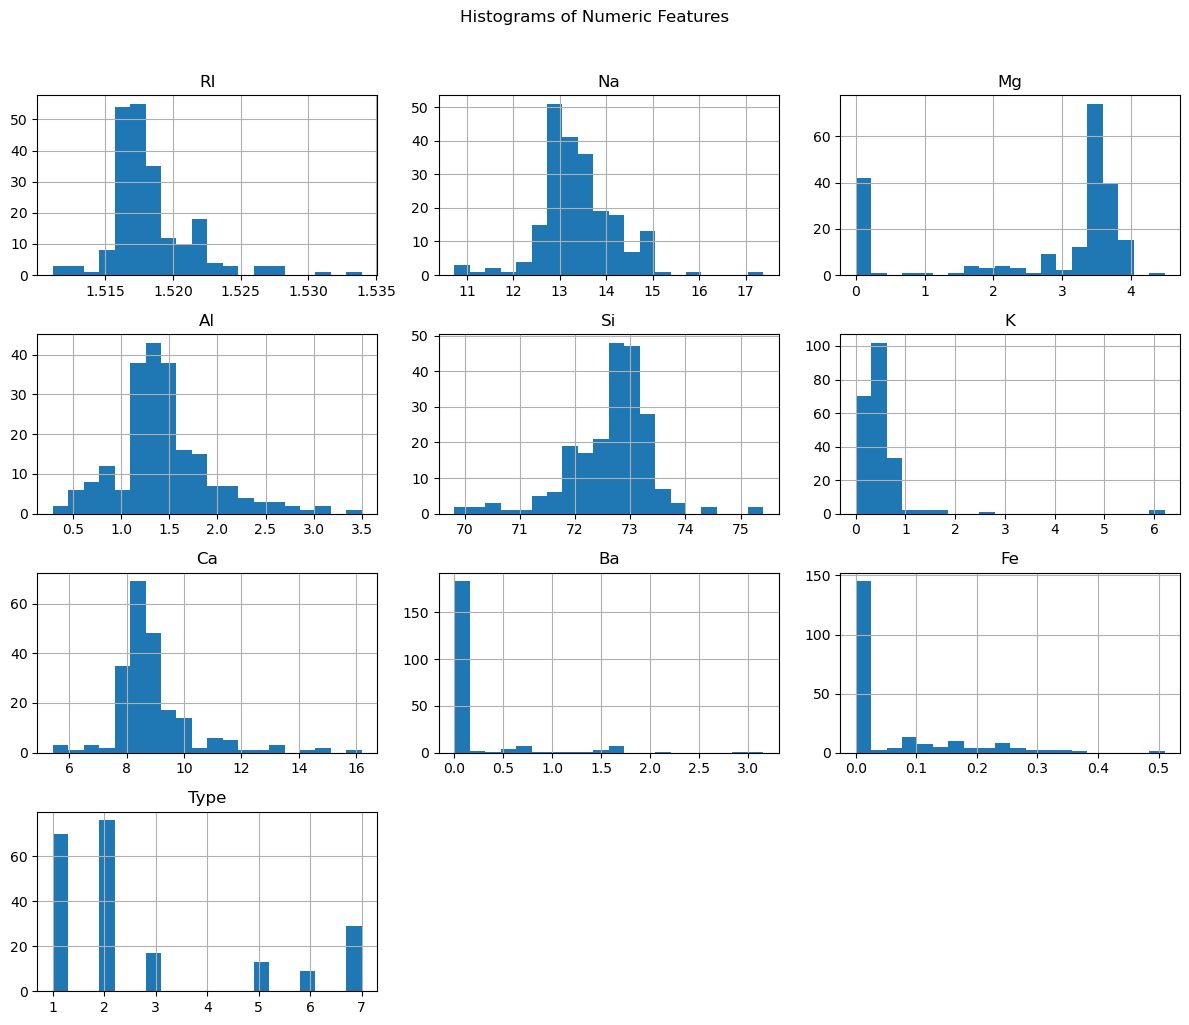

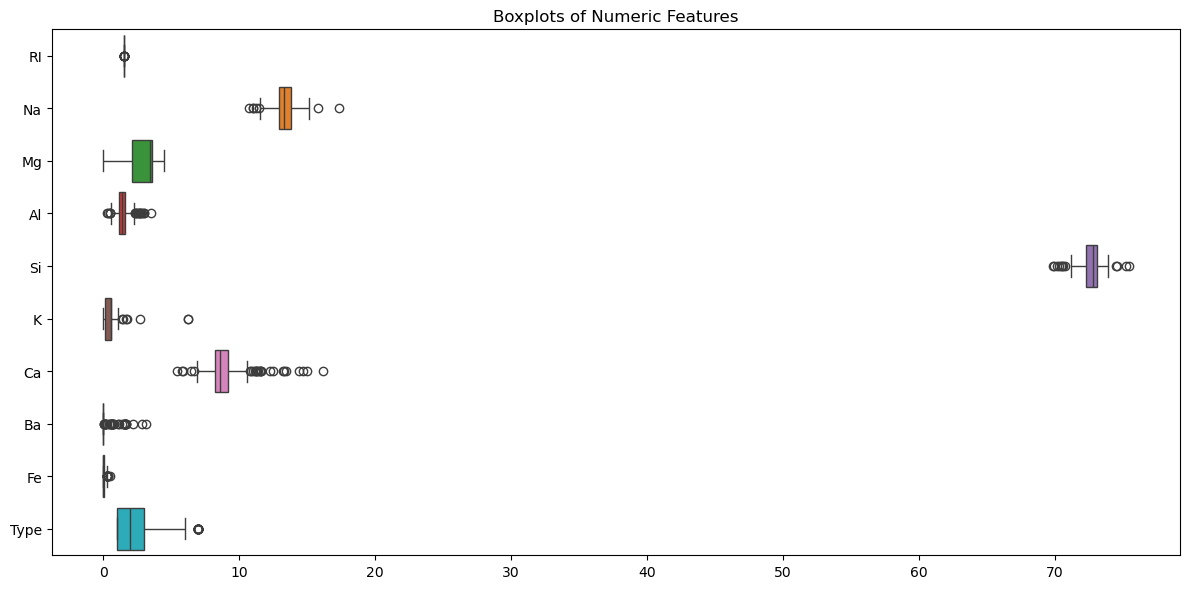

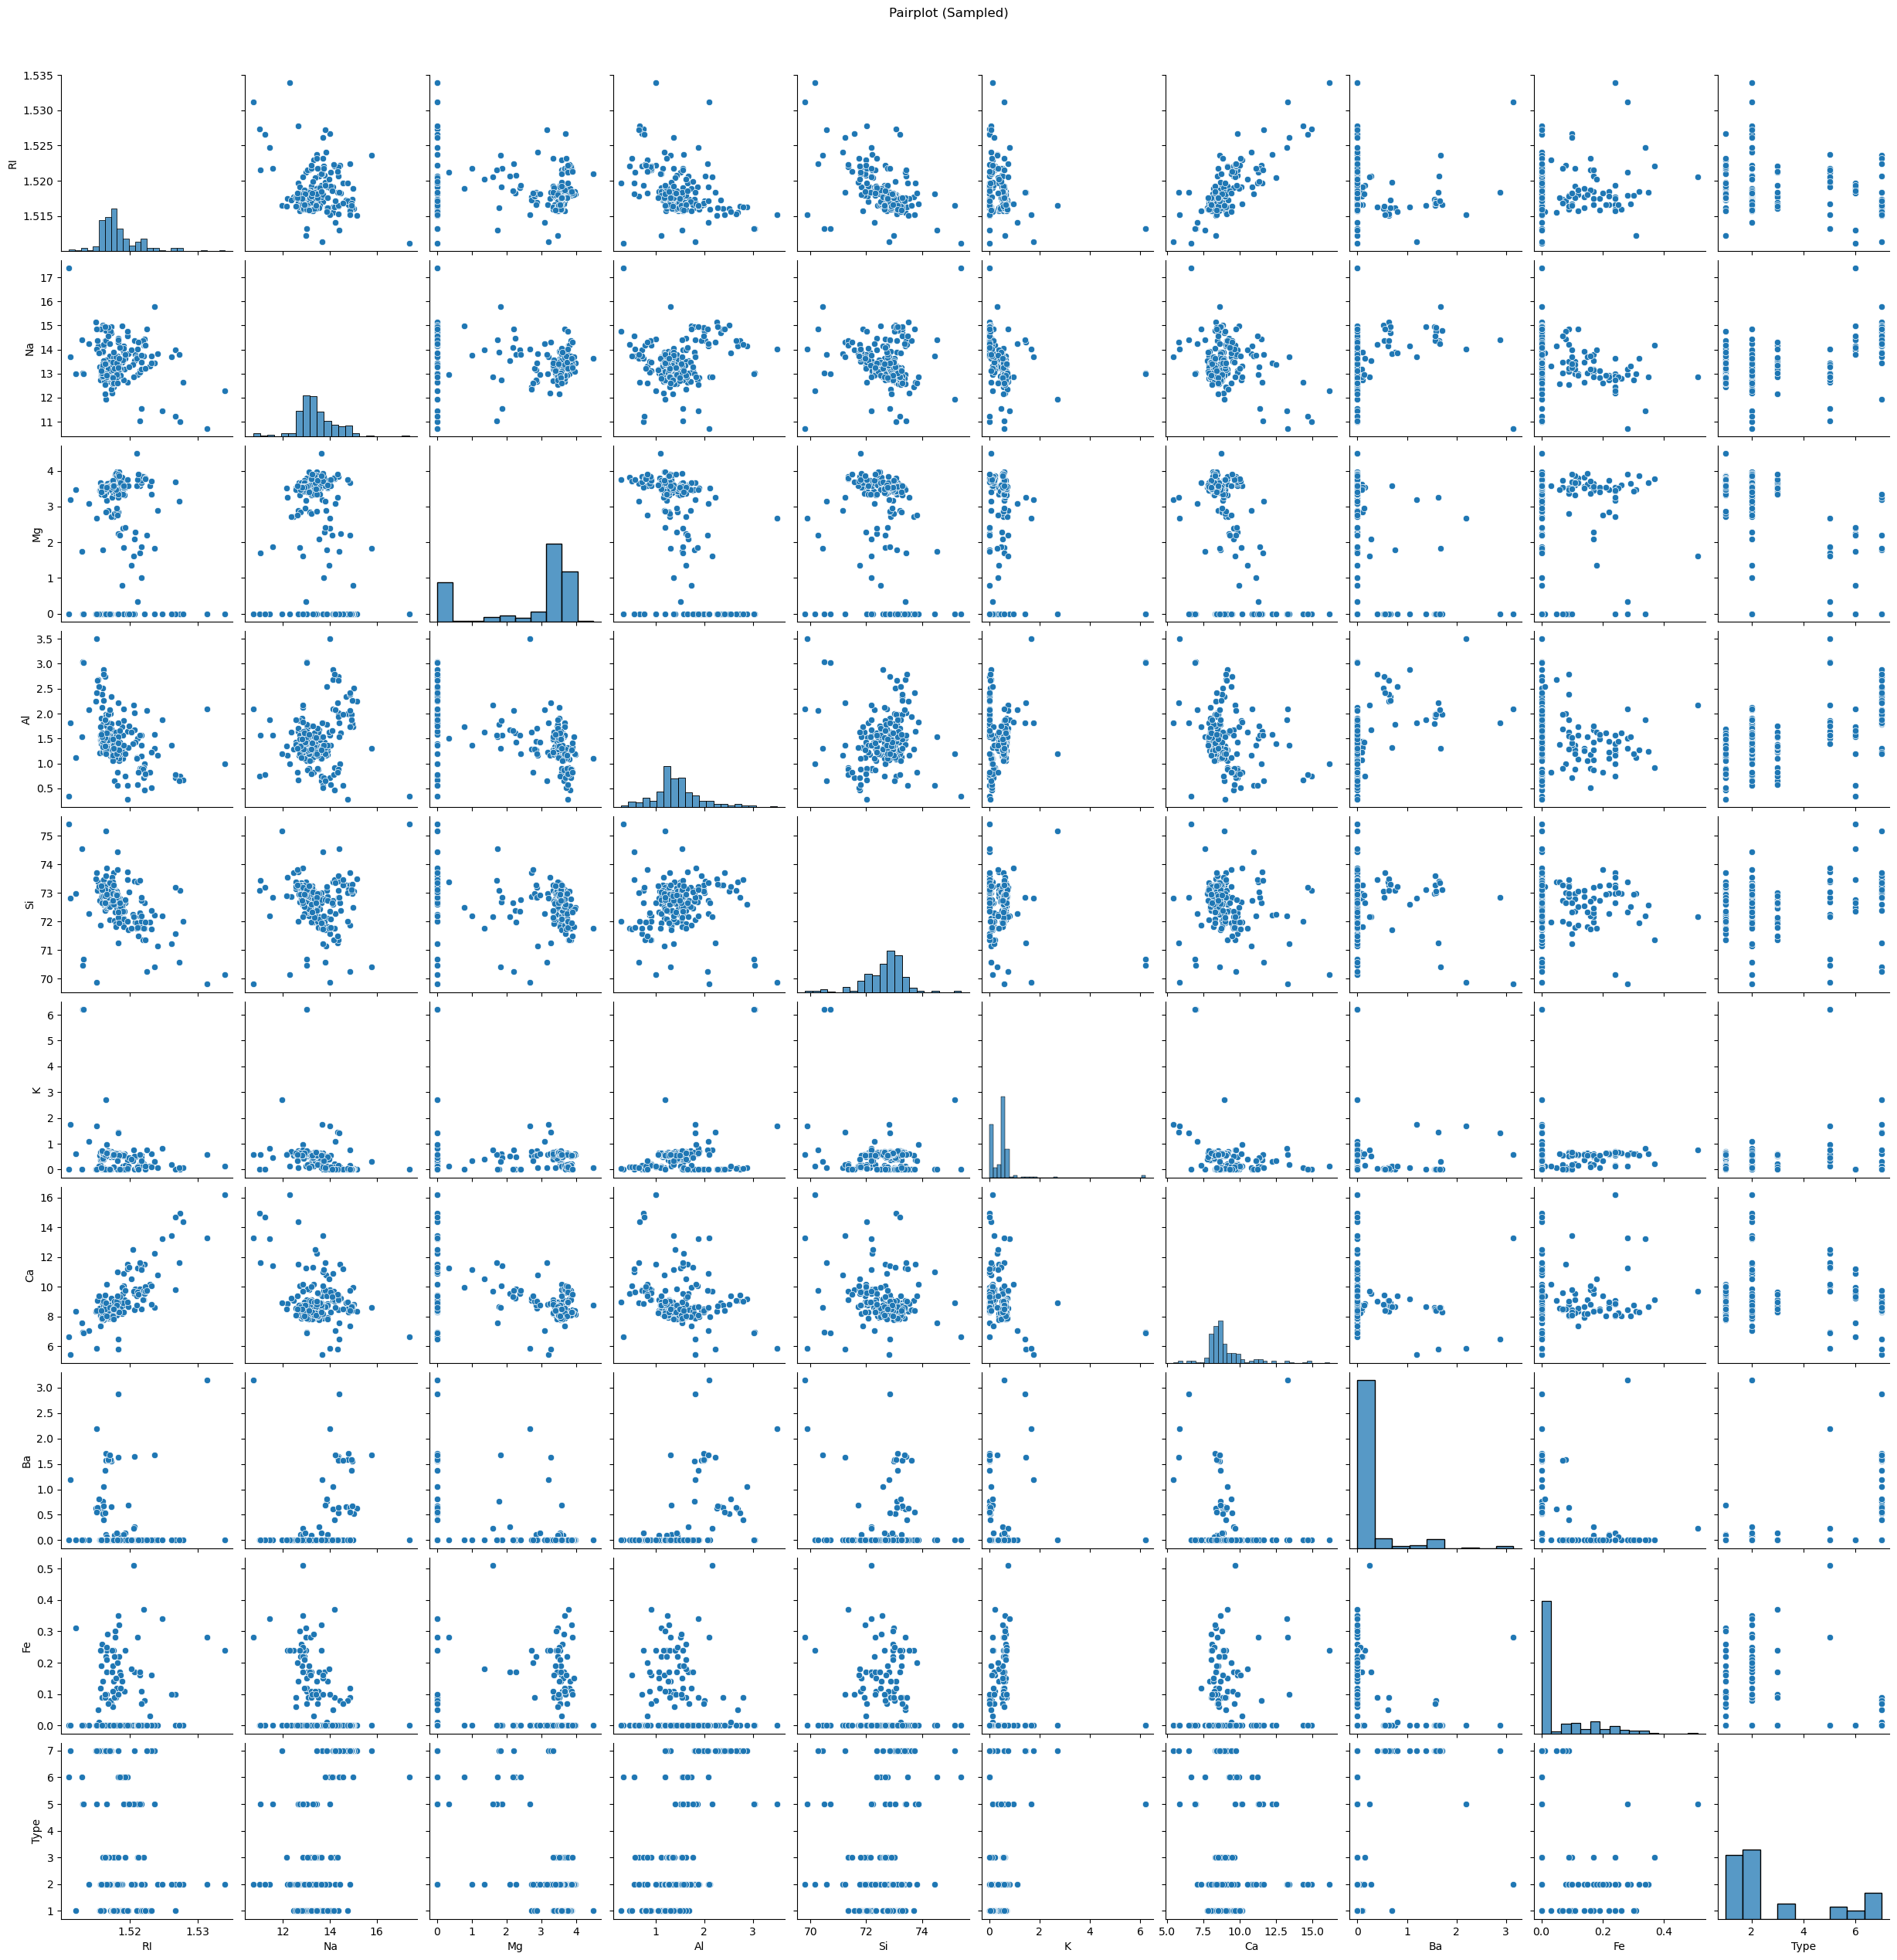

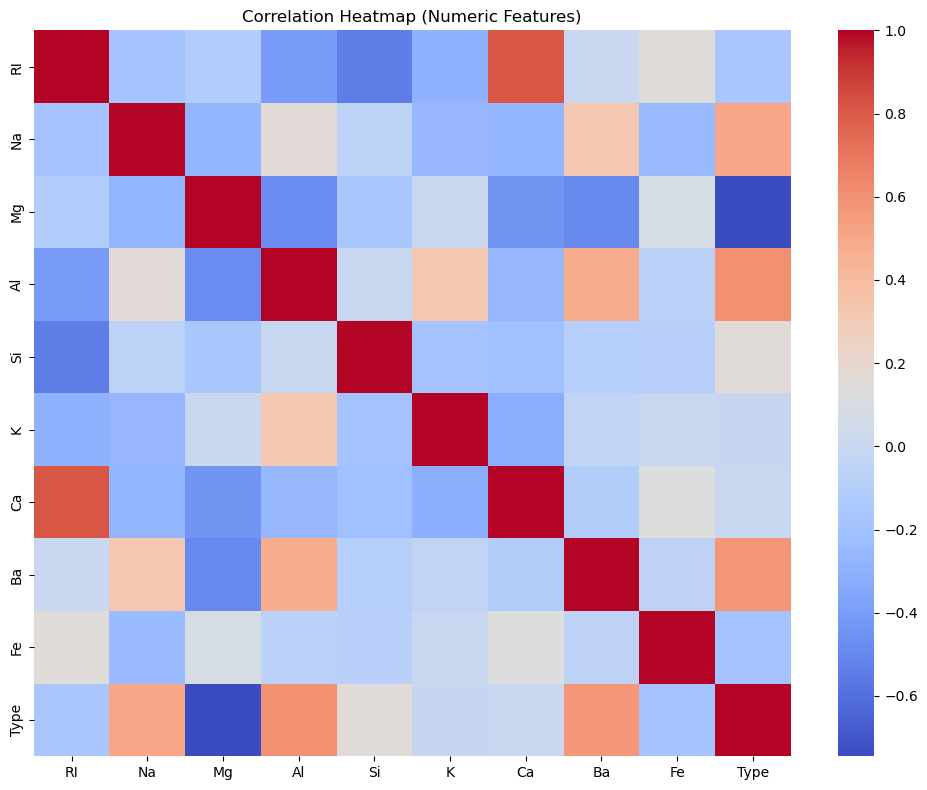

In [5]:
# ===== 2) Data Visualization =====
# Histograms
df[num_cols].hist(figsize=(12, 10), bins=20)
plt.suptitle("Histograms of Numeric Features", y=1.02)
plt.tight_layout()
plt.show()

# Boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[num_cols], orient="h")
plt.title("Boxplots of Numeric Features")
plt.tight_layout()
plt.show()

# Pairplot (sample for speed if needed)
sample_df = df.sample(min(len(df), 400), random_state=42)
sns.pairplot(sample_df[num_cols])
plt.suptitle("Pairplot (Sampled)", y=1.02)
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df[num_cols].corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap (Numeric Features)")
plt.tight_layout()
plt.show()

In [8]:
# ===== 3) Data Preprocessing =====
# Target column in many Glass datasets is 'Type'
target_col = "Type" if "Type" in df.columns else df.columns[-1]

# Split features/target
X = df.drop(columns=[target_col])
y = df[target_col]

# Identify numeric/categorical
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

# Missing value handling (median for numeric, most frequent for categorical)
num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent") if cat_cols else None

X_num = pd.DataFrame(num_imputer.fit_transform(X[num_cols]), columns=num_cols, index=X.index)
if cat_cols:
    X_cat = pd.DataFrame(cat_imputer.fit_transform(X[cat_cols]), columns=cat_cols, index=X.index)
else:
    X_cat = pd.DataFrame(index=X.index)

# One-hot encode categorical if any (Glass usually has none)
if len(X_cat.columns) > 0:
    X_cat_enc = pd.get_dummies(X_cat, drop_first=True)
else:
    X_cat_enc = pd.DataFrame(index=X.index)

X_clean = pd.concat([X_num, X_cat_enc], axis=1)

# Class imbalance check
print("\n=== Class distribution ===")
print(y.value_counts().sort_index())

# Scaling (RF doesn’t need scaling; create a scaled copy if you want to try other models)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_clean), columns=X_clean.columns, index=X_clean.index)


=== Class distribution ===
Type
1    70
2    76
3    17
5    13
6     9
7    29
Name: count, dtype: int64



=== Random Forest Metrics (Test) ===
Accuracy : 0.8140
Precision (macro): 0.8671
Recall    (macro): 0.8484
F1-score  (macro): 0.8446

Classification Report:
              precision    recall  f1-score   support

           1       0.75      0.86      0.80        14
           2       0.79      0.73      0.76        15
           3       1.00      0.67      0.80         3
           5       1.00      1.00      1.00         3
           6       0.67      1.00      0.80         2
           7       1.00      0.83      0.91         6

    accuracy                           0.81        43
   macro avg       0.87      0.85      0.84        43
weighted avg       0.83      0.81      0.81        43



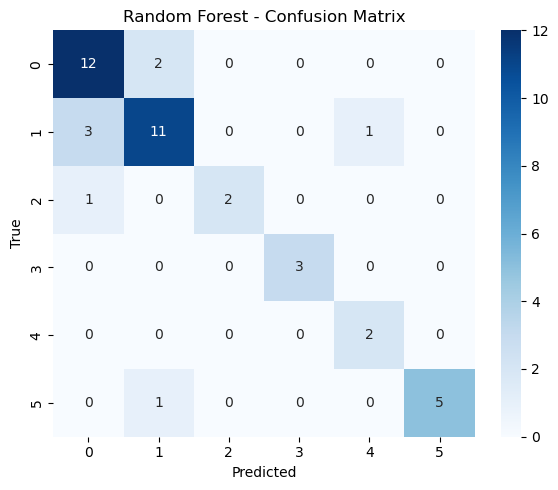


Top 15 Feature Importances (Random Forest):
Mg    0.175409
Ca    0.146016
Na    0.129549
K     0.129075
Al    0.125192
RI    0.108178
Si    0.087156
Ba    0.079508
Fe    0.019917
dtype: float64


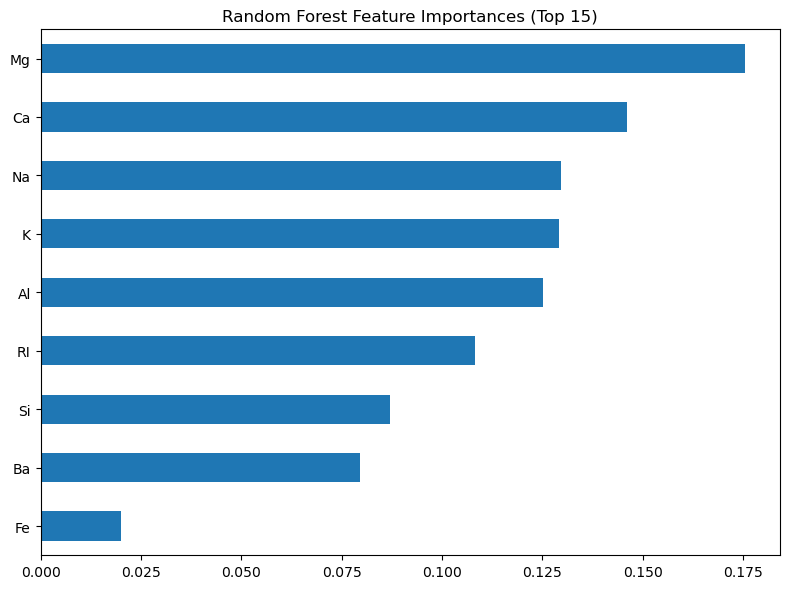

In [10]:
# ===== 4) Random Forest Model Implementation =====
# Train/test split (stratify to preserve class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y, test_size=0.20, random_state=42, stratify=y
)

# Random Forest with class_weight to mitigate imbalance
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

def report_metrics(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec_macro = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec_macro = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average="macro", zero_division=0)
    print(f"\n=== {model_name} Metrics (Test) ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision (macro): {prec_macro:.4f}")
    print(f"Recall    (macro): {rec_macro:.4f}")
    print(f"F1-score  (macro): {f1_macro:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    return acc, prec_macro, rec_macro, f1_macro

rf_scores = report_metrics(y_test, y_pred_rf, "Random Forest")

# Feature importance (top 15)
importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("\nTop 15 Feature Importances (Random Forest):")
print(importances.head(15))
plt.figure(figsize=(8,6))
importances.head(15).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Random Forest Feature Importances (Top 15)")
plt.tight_layout()
plt.show()



=== Bagging (DecisionTree) Metrics (Test) ===
Accuracy : 0.7674
Precision (macro): 0.7996
Recall    (macro): 0.7817
F1-score  (macro): 0.7776

Classification Report:
              precision    recall  f1-score   support

           1       0.75      0.86      0.80        14
           2       0.71      0.67      0.69        15
           3       1.00      0.67      0.80         3
           5       0.67      0.67      0.67         3
           6       0.67      1.00      0.80         2
           7       1.00      0.83      0.91         6

    accuracy                           0.77        43
   macro avg       0.80      0.78      0.78        43
weighted avg       0.78      0.77      0.77        43



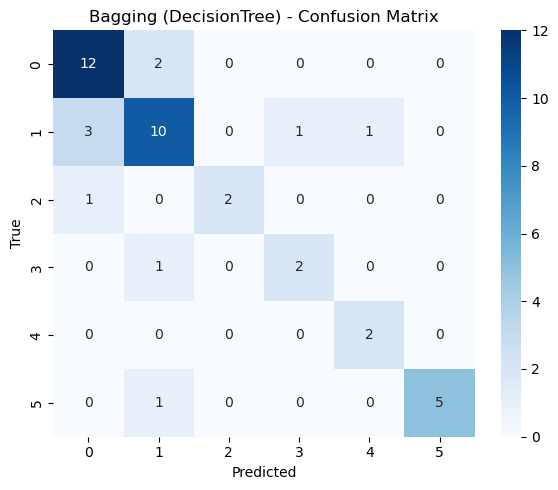


=== AdaBoost Metrics (Test) ===
Accuracy : 0.7209
Precision (macro): 0.8102
Recall    (macro): 0.7135
F1-score  (macro): 0.7225

Classification Report:
              precision    recall  f1-score   support

           1       0.71      0.71      0.71        14
           2       0.65      0.73      0.69        15
           3       1.00      0.33      0.50         3
           5       1.00      0.67      0.80         3
           6       0.67      1.00      0.80         2
           7       0.83      0.83      0.83         6

    accuracy                           0.72        43
   macro avg       0.81      0.71      0.72        43
weighted avg       0.75      0.72      0.72        43



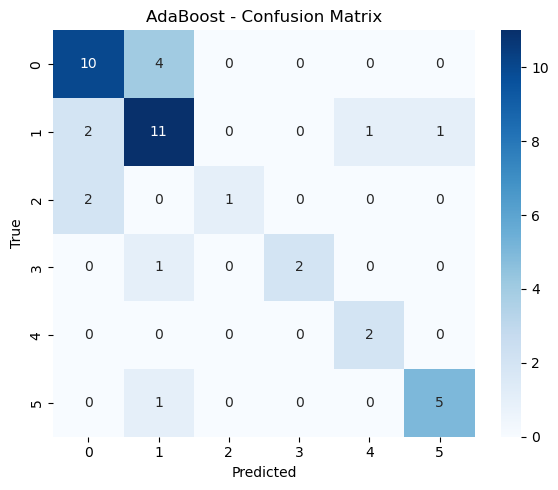


=== GradientBoosting Metrics (Test) ===
Accuracy : 0.7674
Precision (macro): 0.7353
Recall    (macro): 0.7968
F1-score  (macro): 0.7593

Classification Report:
              precision    recall  f1-score   support

           1       0.77      0.71      0.74        14
           2       0.79      0.73      0.76        15
           3       0.67      0.67      0.67         3
           5       0.67      0.67      0.67         3
           6       0.67      1.00      0.80         2
           7       0.86      1.00      0.92         6

    accuracy                           0.77        43
   macro avg       0.74      0.80      0.76        43
weighted avg       0.77      0.77      0.76        43



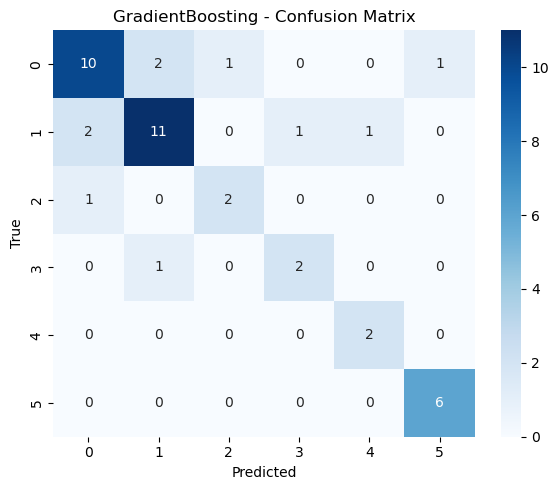


=== Model Comparison (sorted by F1 macro) ===
           Model  Accuracy  Precision (macro)  Recall (macro)  F1 (macro)
    RandomForest  0.813953           0.867063        0.848413    0.844619
         Bagging  0.767442           0.799603        0.781746    0.777569
GradientBoosting  0.767442           0.735348        0.796825    0.759295
        AdaBoost  0.720930           0.810224        0.713492    0.722520


In [14]:
# ===== 5) Bagging & Boosting Methods =====
# Bagging with Decision Trees
bag = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
bag.fit(X_train, y_train)
y_pred_bag = bag.predict(X_test)
bag_scores = report_metrics(y_test, y_pred_bag, "Bagging (DecisionTree)")

# AdaBoost (tree stumps / shallow trees)
ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=2, random_state=42),
    n_estimators=300,
    learning_rate=0.5,
    random_state=42
)
ada.fit(X_train, y_train)
y_pred_ada = ada.predict(X_test)
ada_scores = report_metrics(y_test, y_pred_ada, "AdaBoost")

# Gradient Boosting
gbrt = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)
gbrt.fit(X_train, y_train)
y_pred_gbrt = gbrt.predict(X_test)
gbrt_scores = report_metrics(y_test, y_pred_gbrt, "GradientBoosting")

# ===== Comparison Table =====
summary = pd.DataFrame(
    {
        "Model": ["RandomForest", "Bagging", "AdaBoost", "GradientBoosting"],
        "Accuracy": [rf_scores[0], bag_scores[0], ada_scores[0], gbrt_scores[0]],
        "Precision (macro)": [rf_scores[1], bag_scores[1], ada_scores[1], gbrt_scores[1]],
        "Recall (macro)": [rf_scores[2], bag_scores[2], ada_scores[2], gbrt_scores[2]],
        "F1 (macro)": [rf_scores[3], bag_scores[3], ada_scores[3], gbrt_scores[3]],
    }
).sort_values(by="F1 (macro)", ascending=False)

print("\n=== Model Comparison (sorted by F1 macro) ===")
print(summary.to_string(index=False))


# Additional Notes:

# 1. Explain Bagging and Boosting methods. How is it different from each other.

Bagging and boosting are both ensemble learning techniques that aim to improve the performance of machine learning models by combining the predictions of multiple base learners. These approaches differ in their methodologies, strategies, and goals. In this detailed explanation, we’ll delve into bagging and boosting, exploring their key concepts, algorithms, advantages, and potential challenges.
Bagging (Bootstrap Aggregating):
Bagging is a popular ensemble learning technique that focuses on reducing variance and improving the stability of machine learning models. The term “bagging” is derived from the idea of creating multiple subsets or bags of the training data through a process known as bootstrapping. Bootstrapping involves randomly sampling the dataset with replacement to generate multiple subsets of the same size as the original data. Each of these subsets is then used to train a base learner independently.

One of the primary goals of bagging is to reduce overfitting by exposing each base learner to slightly different variations of the training data. Since each subset is created by sampling with replacement, some instances may be duplicated while others may be omitted. This diversity helps the ensemble model generalize well to unseen data.

The most well-known algorithm for bagging is the Random Forest. In a Random Forest, a collection of decision trees is built, each trained on a different subset of the data. During the training process, each tree is constructed by selecting a random subset of features for each split, adding an extra layer of randomness and diversity to the ensemble. The final prediction is then made by averaging or taking a vote among the predictions of individual trees.

One key advantage of bagging is its ability to handle noisy data and outliers effectively. Since the ensemble model aggregates predictions from multiple base learners, the impact of outliers on the overall performance is reduced. Additionally, bagging is parallelizable, as each base learner can be trained independently, leading to efficient and scalable implementations.

Despite its strengths, bagging might not significantly improve the performance of an already stable model or one that is not prone to overfitting. It is particularly useful when dealing with complex models that have high variance, such as deep decision trees or neural networks.

Boosting:
Boosting, like bagging, is an ensemble learning technique, but it aims to improve the performance of weak learners by combining them in a sequential manner. The core idea behind boosting is to give more weight to misclassified instances during the training process, enabling subsequent learners to focus on the mistakes made by their predecessors.

Unlike bagging, boosting does not rely on bootstrapped subsets of the data. Instead, it assigns weights to each instance in the training set and adjusts these weights throughout the boosting iterations. In each iteration, a new weak learner is trained on the data, and the weights of misclassified instances are increased. This allows the subsequent learner to pay more attention to the previously misclassified examples.

The most well-known boosting algorithm is AdaBoost (Adaptive Boosting). In AdaBoost, the weak learners are usually simple models with low predictive power, such as shallow decision trees or stumps (trees with a single split). Each weak learner is trained sequentially, and at each iteration, the weights of misclassified instances are increased, forcing the model to focus on the difficult-to-classify examples.

AdaBoost assigns a weight to each weak learner based on its performance, and the final prediction is made by combining the weighted predictions of all weak learners. Instances that are consistently misclassified by the ensemble receive higher weights, allowing subsequent weak learners to give more emphasis to these challenging cases.

One of the significant advantages of boosting is its ability to handle complex relationships in the data and improve the performance of weak learners significantly. Boosting often outperforms bagging when it comes to reducing both bias and variance. However, boosting is more sensitive to noisy data and outliers compared to bagging.

Differences Between Bagging and Boosting:
Sequential vs. Parallel:
Bagging: The base learners are trained independently in parallel, as each learner works on a different subset of the data. The final prediction is typically an average or vote of all base learners.
Boosting: The base learners are trained sequentially, and each learner focuses on correcting the mistakes of its predecessors. The final prediction is a weighted sum of the individual learner predictions.

# 2. Explain how to handle imbalance in the data.

Imbalanced data is a common problem in machine learning, where one class has a significantly higher number of observations than the other. This can lead to biased models and poor performance on the minority class. In this blog, we will discuss techniques for handling imbalanced data and improving model performance.   

Imbalanced data refers to datasets where the distribution of class labels is not equal, with one class having a significantly higher number of observations than the other. This can be a problem for machine learning algorithms, as they can be biased towards the majority class and perform poorly on the minority class. 

Techniques for handling imbalanced data
Dealing with imbalanced data is a common problem in data science, where the target class has an uneven distribution of observations. In classification problems, this can lead to models that are biased toward the majority class, resulting in poor performance of the minority class. To handle imbalanced data, various techniques can be employed. 

1. Resampling techniques
2. Data augmentation
3. Synthetic minority over-sampling technique (SMOTE)
4. Ensemble techniques
5. One-class classification
6. Cost-sensitive learning
7. Evaluation metrics for imbalanced data
